In [141]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use("ggplot")

In [142]:
df=yf.download("BTC-USD",progress=False)

#MOVING AVG
df["SMA21"]=df["Close"].rolling(21).mean()
df["SMA9"]=df["Close"].rolling(9).mean()
df["SMA30"]=df["Close"].rolling(30).mean()
df["SMA10"]=df["Close"].rolling(10).mean()
df["Relation"]=df["SMA9"]/df["SMA21"]

#BOLLINGER
df["SMA20"]=df["Close"].rolling(20).mean()
df["stdClose20"]=df["Close"].rolling(20).std()

#RSI
df["Diff"]=df["Close"].diff(1)
df["Positive"]=df["Diff"]
df["Negative"]=df["Diff"]
df.loc[df["Diff"]<0,"Positive"]=0
df.loc[df["Diff"]>0,"Negative"]=0
df["Negative"]=abs(df["Negative"])
df["PosSum20"]=df["Positive"].rolling(14).sum()
df["NegSum20"]=df["Negative"].rolling(14).sum()
df["RSI"]=100-100/(1+(df["PosSum20"]/df["NegSum20"]))
prev=None
for i in df.index:
    if(prev!=None):
        condition1=((df.loc[df.index==prev, "RSI"].values[0]<70) and (df.loc[df.index==i, "RSI"].values[0]>=70))
        condition2=((df.loc[df.index==prev, "RSI"].values[0]>30) and (df.loc[df.index==i, "RSI"].values[0]<=30))
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
        if condition1: df.loc[i, "3070POINTS"] = "red"  #top
        if condition1: df.loc[i, "transp"] = 1  #top
        if condition2: df.loc[i, "3070POINTS"] = "green"  #bottom
        if condition2: df.loc[i, "transp"] = 1  #bottom
    else:
        df.loc[i, "transp"] = 0
        df.loc[i, "3070POINTS"] = "blue"
    prev=i

# df

# df.head(5)
#START DATE 2014-09-17


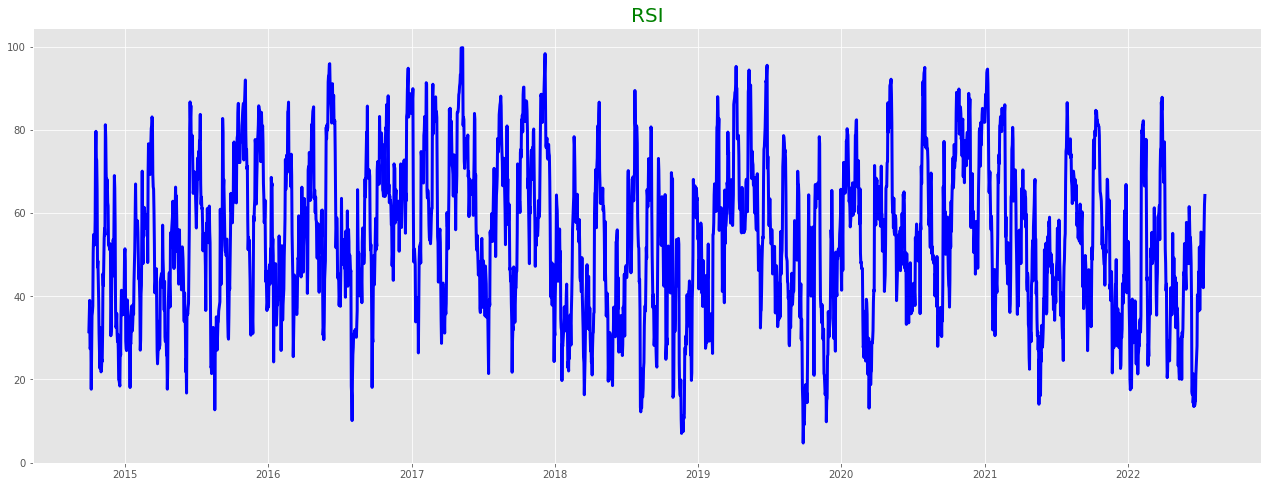

In [143]:
plt.figure(figsize=(22,8))
plt.plot(df["RSI"],color="blue",linewidth=3)
plt.title("RSI",fontsize=20,color="green")

plt.show()

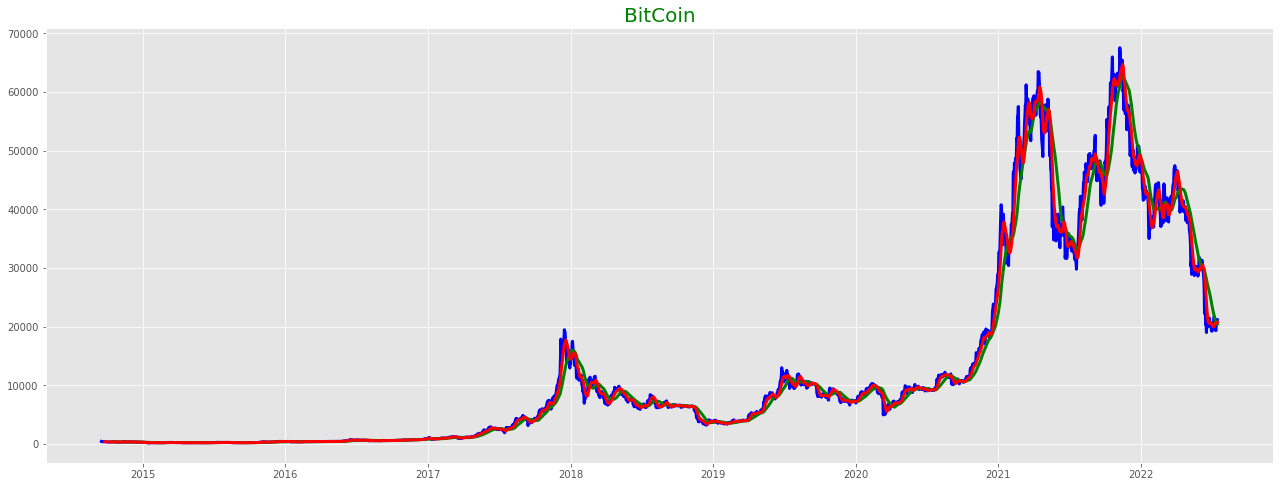

In [144]:
plt.figure(figsize=(22,8))
plt.plot(df["Close"],color="blue",linewidth=3)
plt.plot(df["SMA30"],color="green",linewidth=3)
plt.plot(df["SMA10"],color="red",linewidth=3)
plt.title("BitCoin",fontsize=20,color="green")

plt.show()

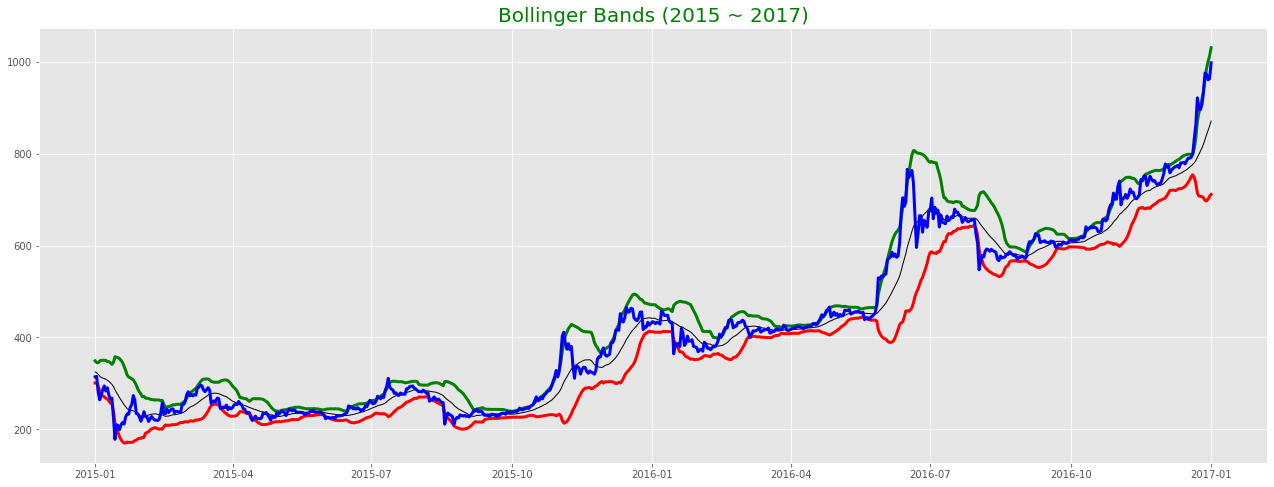

In [145]:
df2015to2017 = df.loc['2015-01-01':'2017-01-01']

plt.figure(figsize=(22,8))
plt.plot(df2015to2017["SMA20"]+2*df2015to2017["stdClose20"],color="green",linewidth=3)
plt.plot(df2015to2017["SMA20"]-2*df2015to2017["stdClose20"],color="red",linewidth=3)
plt.plot(df2015to2017["SMA20"],color="black",linewidth=1)
plt.plot(df2015to2017["Close"],color="blue",linewidth=3)
plt.title("Bollinger Bands (2015 ~ 2017)",fontsize=20,color="green")

plt.show()

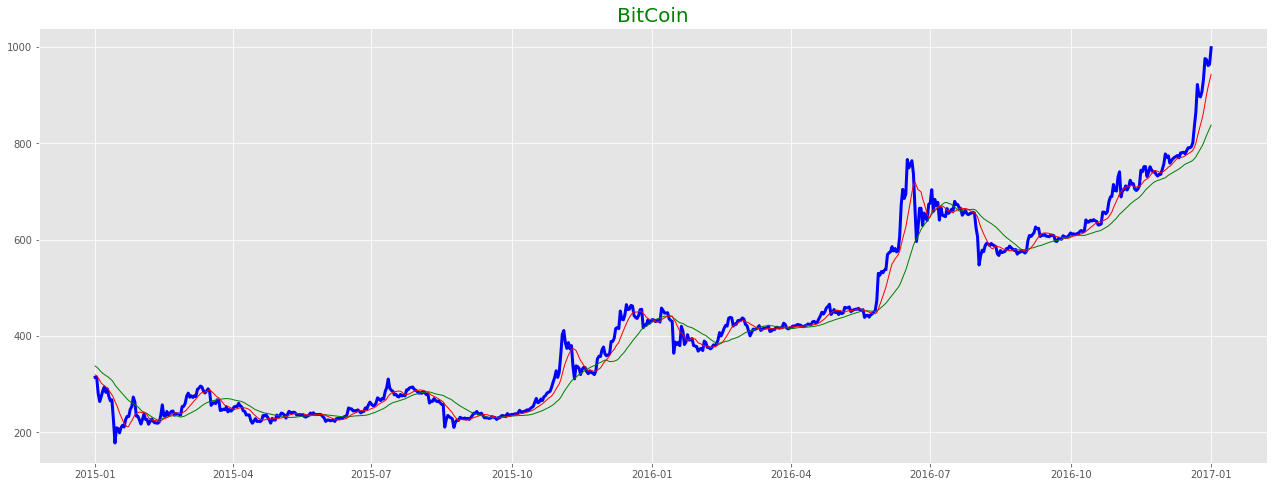

In [146]:
plt.figure(figsize=(22,8))
plt.plot(df2015to2017["Close"],color="blue",linewidth=3)
plt.plot(df2015to2017["SMA30"],color="green",linewidth=1)
plt.plot(df2015to2017["SMA10"],color="red",linewidth=1)
plt.title("BitCoin",fontsize=20,color="green")

plt.show()

In [283]:
Buy, Sell = [],[]
cash_data_data=[]
df_log=pd.DataFrame()
signal=0
cash=1000
amount=cash
cash_data=[cash]
trades=0
previous_top=0
for i in range(len(df["Close"])):
    if df["Close"].iloc[i]>previous_top:
        previous_top=df["Close"].iloc[i]
    if df["Relation"].iloc[i]>1.02 and signal==0:
        signal+=1
        Buy.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
        cash-=maximo*(df["Open"].iloc[i+1]+comission)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
    if df["Relation"].iloc[i]<0.98 and signal==1:
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]+comission)
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        trades+=1
    if signal == 1 and (df["Close"].iloc[i]/previous_top<0.7):
        previous_top = 0
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]+comission)
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        trades+=1

In [284]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2014-10-18,Buy,383.976013,2,767.952026,3.839760
2014-10-29,Sell,357.088989,2,714.177979,3.570890
2014-11-13,Buy,427.273010,2,854.546021,4.272730
2014-11-29,Sell,376.152008,2,752.304016,3.761520
2015-01-30,Buy,232.772003,3,698.316010,2.327720
...,...,...,...,...,...
2022-02-24,Sell,37278.566406,5,186392.832031,372.785664
2022-03-09,Buy,38742.816406,5,193714.082031,387.428164
2022-04-12,Sell,39533.714844,5,197668.574219,395.337148


In [285]:
if df_log.iloc[-1]["Type"]=="Buy":
    df_log=df_log.iloc[:-1]
    Buy=Buy[:-1]

In [286]:
#buy & hold chart
buy_hold=[]
datas_buy_hold=[]
shares=df_log["Quantity"][0]
for a in range(len(df)):
    buy_hold.append(df["Close"].iloc[a]*shares)
    datas_buy_hold.append(df.index[a])
minimo_buy_hold=min(buy_hold)
buy_hold=pd.DataFrame(pd.Series(buy_hold))
datas_buy_hold=pd.DataFrame(pd.Series(datas_buy_hold))
buy_hold["Datas"]=datas_buy_hold
buy_hold=buy_hold.set_index("Datas")
min_budget=min(cash_data)
cash_data=pd.DataFrame(pd.Series(cash_data))
t_f=df_log["Type"]=="Sell"
cash_data_data=df_log[t_f]
cash_data_data=cash_data_data.index
cash_data_data=pd.DataFrame(pd.Series(cash_data_data))
cash_data["Dates"]=cash_data_data
cash_data=cash_data.set_index("Dates")
# TEMOS QUE COLOCAR OS VALORES 1 PARA BAIXO, PQ O CASH_DATA JA COMECA COM 1 VALOR
cash_data=cash_data.shift(-1) 

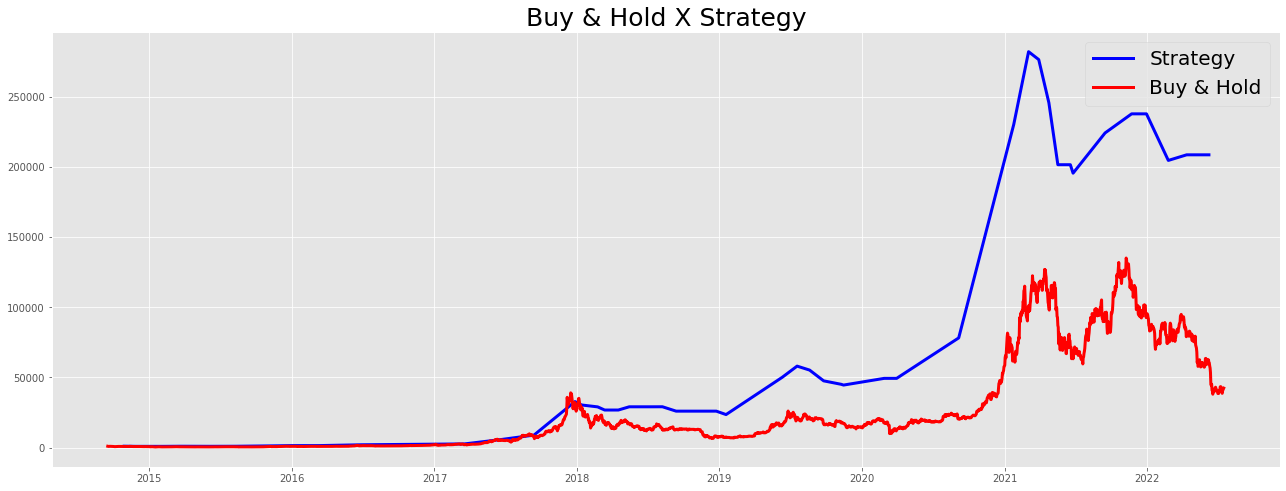

In [287]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="blue",label="Strategy",linewidth=3)
plt.plot(buy_hold,color="red",label="Buy & Hold",linewidth=3)
plt.title("Buy & Hold X Strategy",fontsize=25)
plt.legend(fontsize=20)
plt.show()

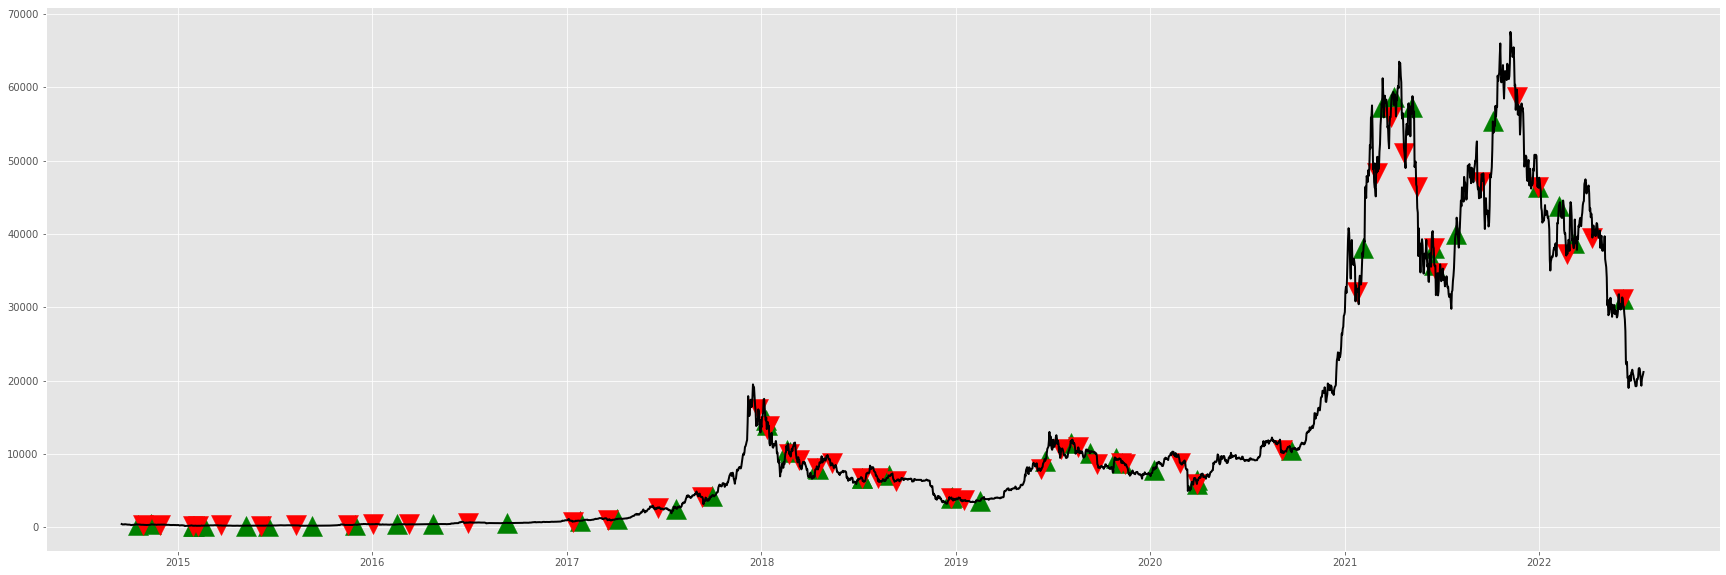

In [288]:
plt.figure(figsize=(30,10))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=400)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=400)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)

In [289]:
df["Adj Close"]

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2022-07-12    19323.914062
2022-07-13    20212.074219
2022-07-14    20569.919922
2022-07-15    20836.328125
2022-07-16    21190.316406
Name: Adj Close, Length: 2860, dtype: float64

In [290]:
print(f"Period: {df.index.day[0]}/{df.index.month[0]}/{df.index.year[0]} - {df.index.day[-1]}/{df.index.month[-1]}/{df.index.year[-1]}")
print("-="*15)
print(cash_data.iloc[-2][0])
strategy_return=cash_data.iloc[-2][0]/cash_data.iloc[0][0].round(2)
print(f"Strategy Total Return: {(cash_data.iloc[-2][0]/cash_data.iloc[0][0]).round(2)*100}%")
x=df["Close"][-1]/df["Close"][0]
print(f"Buy & Hold Total Return {(x*100).round(2)}% ")
print("-="*15)
print(f"Strategy Annual Return: {(((1+strategy_return)**(252/len(df))-1)*100).round(2)}%")
print(f"Buy & Hold Annual Return: {(((1+x)**(252/len(df))-1)*100).round(2)}%")
print("-="*15)
print(f"Trades: {trades}")
print(f"Trades/Year: {trades/(len(df)/252)}")
print("-="*15)
print(f"Maximum Strategy drawdown: {(((min_budget-amount)/amount)*100).round(2)}%")
print(f"Maximum Buy & Hold drawdown: {(((min(buy_hold[0])-amount)/amount)*100)}%")

Period: 17/9/2014 - 16/7/2022
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
208745.35827667243
Strategy Total Return: 22073.0%
Buy & Hold Total Return 4633.44% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Annual Return: 60.95%
Buy & Hold Annual Return: 40.48%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Trades: 49
Trades/Year: 4.317482517482517
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Maximum Strategy drawdown: -15.76%
Maximum Buy & Hold drawdown: -64.37940063476563%


In [291]:
import vectorbt as vbt

price = vbt.YFData.download('BTC-USD', interval="1d").get('Close')

In [156]:


pf = vbt.Portfolio.from_holding(price, init_cash=1000)
pf.plot()


FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [157]:
pf.total_profit()

45334.44204063267

In [158]:
Sma20 = vbt.MA.run(price, 20)
Sma10 = vbt.MA.run(price, 10)
buy = Sma10.ma_above(Sma20)
sell = Sma20.ma_above(Sma10)


In [159]:
pf = vbt.Portfolio.from_signals(price, buy, sell, sl_stop=0.005)

In [160]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [161]:
pf.total_profit()

8126.364127517533

In [162]:
pf = vbt.Portfolio.from_signals(price, buy, sell)

In [163]:
pf.plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [164]:
pf.total_profit()

11417.927111028032